In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from censusAPI import myAPI ## User defined script storing private census API key
import requests
import json
import io
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pylab as plt
from sklearn.model_selection import GridSearchCV
from scipy.stats.stats import pearsonr   
from sklearn import tree
from IPython.display import Image  
import pydotplus
#import pylab as plot

#plt.style.use("fivethirtyeight")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Get the data

### NYC Open Data
Sources (including data dictionaries/documentation): 
- 2015 NYC Tree Census: https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh
- 2015 NYC 311 Complaints: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9

In [2]:
raw_trees = pd.read_csv('https://data.cityofnewyork.us/api/views/uvpi-gqnh/rows.csv')
print("Shape of dataframe:", raw_trees.shape)
raw_trees.head()

Shape of dataframe: (683788, 45)


,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
0,180683,348711,08/27/2015,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,4073900,New York,40.723092,-73.844215,1027431.148,202756.7687,29.0,739.0,4052307.0,4.022210e+09
1,200540,315986,09/03/2015,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,4097300,New York,40.794111,-73.818679,1034455.701,228644.8374,19.0,973.0,4101931.0,4.044750e+09
2,204026,218365,09/05/2015,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.717581,-73.936608,1001822.831,200716.8913,34.0,449.0,3338310.0,3.028870e+09
3,204337,217969,09/05/2015,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.713537,-73.934456,1002420.358,199244.2531,34.0,449.0,3338342.0,3.029250e+09
4,189565,223043,08/30/2015,21,0,OnCurb,Alive,Good,Tilia americana,American linden,...,3016500,New York,40.666778,-73.975979,990913.775,182202.4260,39.0,165.0,3025654.0,3.010850e+09


The full 311 dataset contains over 18 million records with over 40 attributes. To speed up reading in the data, the data was filtered before downloading. The following filters were applied: 
- 'Created Date' between 01/01/2015 and 12/31/2015
- 'Agency Name' contains 'parks'

In [3]:
raw_complaints = pd.read_csv('data/311_Service_Requests_from_2010_to_Present.csv')
print("Shape of dataframe:", raw_complaints.shape)
raw_complaints.head()

Shape of dataframe: (88203, 41)


,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,29609033,01/01/2015 01:06:43 AM,01/20/2015 09:19:14 AM,DPR,Department of Parks and Recreation,Illegal Tree Damage,Branches Damaged,NaN,11417.0,133-03 96 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.675856,-73.840822,"(40.67585578806105, -73.84082188415933)"
1,29609067,01/01/2015 01:57:26 AM,01/01/2015 02:12:09 AM,DPR,Department of Parks and Recreation,DPR Internal,Aided/Injury,Park,11215.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29615943,01/01/2015 04:17:28 AM,01/07/2015 11:46:33 AM,DPR,Department of Parks and Recreation,Maintenance or Facility,Unsecured Facility,Park,10021.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29618044,01/01/2015 09:14:54 AM,01/01/2015 09:36:58 AM,DPR,Department of Parks and Recreation,DPR Internal,Aided/Injury,Park,10034.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.867817,-73.923625,"(40.867816992848674, -73.92362504351495)"
4,29614686,01/01/2015 09:22:49 AM,11/10/2015 09:55:56 AM,DPR,Department of Parks and Recreation,New Tree Request,For One Address,NaN,11230.0,325 AVENUE M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.616744,-73.971653,"(40.616743691060684, -73.97165262290905)"


### American Community Survey Data (Census)

The below function retrieves data from the 5 year ACS: https://www.census.gov/data/developers/data-sets/acs-5year.html

More info on using Census API: https://www.census.gov/data/developers/data-sets/acs-5year.html
Note:

**Note:** To run this code, you'll need your own Census API Key. Request a key at: https://api.census.gov/data/key_signup.html

To ensure the privacy of my API key, I created a script file (censusAPI.py) and saved my API keyinside as

myAPI = "XXXXXXXXXXXXXX"

If attempting to rerun this code, please: Request an API key yourself and create a censusAPI.py script storing your personal key

In [4]:
def censusDetailed(variable):
    '''
    Returns a dataframe of an inputted census variables (from detailed tables) at the census tract level
    Requires predefined variables: states
    Optional: Filter based on predefined counties variables 
    '''
    perm_df = pd.DataFrame()

    for state in states:
        url = "https://api.census.gov/data/2016/acs/acs5?get=NAME," + variable + "&for=tract:*&in=state:" + state + "&key=" + myAPI
        resp = requests.request('GET', url)
        aff1y = json.loads(resp.text)
        
        resp = requests.request('GET', url).content
        temp_df = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
        print(temp_df.shape)
        perm_df = perm_df.append(temp_df)
    
    # Filter it based on a list of counties defined by user 
    # Can be hashed out if user does not want to filter 
    perm_df = perm_df[perm_df['county'].isin(counties)]
    print(perm_df.shape)
    
    return perm_df

In [5]:
## Defining state and county numbers for NYC
states = ['36']
counties = [61, 47, 81, 85, 5]

In [6]:
variable = 'B01001_001E'
word = 'Total_Population'

total_pop = censusDetailed(variable)
total_pop.rename(columns={variable : word}, inplace=True)
total_pop.drop('Unnamed: 5', axis=1, inplace=True)
total_pop.head(3)

(4918, 6)
(2167, 6)


,NAME,Total_Population,state,county,tract
88,"Census Tract 1, Bronx County, New York",7503,36,5,100
89,"Census Tract 2, Bronx County, New York",5251,36,5,200
90,"Census Tract 4, Bronx County, New York",5980,36,5,400


In [7]:
variable = 'B20002_001E'
word = 'Median_Income'

income_total = censusDetailed(variable)
income_total.rename(columns={variable : word}, inplace=True)
income_total.drop('Unnamed: 5', axis=1, inplace=True)
income_total.head(3)

(4918, 6)
(2167, 6)


,NAME,Median_Income,state,county,tract
88,"Census Tract 1, Bronx County, New York",11347,36,5,100
89,"Census Tract 2, Bronx County, New York",35406,36,5,200
90,"Census Tract 4, Bronx County, New York",42492,36,5,400


In [8]:
variable = 'B25008_002E'
word = 'Home_Owners'

home_owners = censusDetailed(variable)
home_owners.rename(columns={variable : word}, inplace=True)
home_owners.drop('Unnamed: 5', axis=1, inplace=True)
home_owners.head(3)

(4918, 6)
(2167, 6)


,NAME,Home_Owners,state,county,tract
88,"Census Tract 1, Bronx County, New York",0,36,5,100
89,"Census Tract 2, Bronx County, New York",3071,36,5,200
90,"Census Tract 4, Bronx County, New York",4374,36,5,400


In [9]:
census_data = pd.merge(total_pop, income_total[['NAME', 'Median_Income']], on='NAME')
census_data = census_data.merge(home_owners[['NAME', 'Home_Owners']], on='NAME')
census_data['home_perc'] = census_data['Home_Owners'] / census_data['Total_Population']
census_data.head()

,NAME,Total_Population,state,county,tract,Median_Income,Home_Owners,home_perc
0,"Census Tract 1, Bronx County, New York",7503,36,5,100,11347,0,0.000000
1,"Census Tract 2, Bronx County, New York",5251,36,5,200,35406,3071,0.584841
2,"Census Tract 4, Bronx County, New York",5980,36,5,400,42492,4374,0.731438
3,"Census Tract 16, Bronx County, New York",6056,36,5,1600,22279,1001,0.165291
4,"Census Tract 19, Bronx County, New York",2682,36,5,1900,31031,246,0.091723


In [10]:
## Adding a GEOID column for common varible to merge on later
## GEOID is a unique identifier used by the Census Bureau 
census_data['county'] = '00' + census_data['county'].astype(str)
census_data['county'] = census_data['county'].str[-3:]
census_data['state'] = census_data['state'].astype(str)
census_data['state'] = census_data['state'].str.replace('9', '09')
census_data['tract'] = '000' + census_data['tract'].astype(str)
census_data['tract'] = census_data['tract'].str[-6:]
census_data['GEOID'] = census_data['state'].astype(str) + census_data['county'].astype(str) + census_data['tract'].astype(str)
print(census_data.shape)
census_data.head()

(2167, 9)


,NAME,Total_Population,state,county,tract,Median_Income,Home_Owners,home_perc,GEOID
0,"Census Tract 1, Bronx County, New York",7503,36,005,000100,11347,0,0.000000,36005000100
1,"Census Tract 2, Bronx County, New York",5251,36,005,000200,35406,3071,0.584841,36005000200
2,"Census Tract 4, Bronx County, New York",5980,36,005,000400,42492,4374,0.731438,36005000400
3,"Census Tract 16, Bronx County, New York",6056,36,005,001600,22279,1001,0.165291,36005001600
4,"Census Tract 19, Bronx County, New York",2682,36,005,001900,31031,246,0.091723,36005001900


#### Census Tract Shapefile

Source: https://www.census.gov/geo/maps-data/data/cbf/cbf_tracts.html 
- Download 2015 file for New York state

In [11]:
census_shp = gpd.GeoDataFrame.from_file('data/cb_2015_36_tract_500k/cb_2015_36_tract_500k.shp')
census_shp = census_shp[['COUNTYFP', 'TRACTCE', 'GEOID', 'geometry']]
census_shp = census_shp.to_crs({'init': 'epsg:4326'})
print(census_shp.crs)
census_shp.head(3)

{'init': 'epsg:4326'}


,COUNTYFP,TRACTCE,GEOID,geometry
0,001,000502,36001000502,"POLYGON ((-73.79496 42.66871, -73.790798999999..."
1,001,013507,36001013507,"POLYGON ((-73.802734 42.763943, -73.796492 42...."
2,001,014612,36001014612,"POLYGON ((-74.045469 42.711973, -74.0415709999..."


# Data merging & cleaning

In [12]:
## Cleaning census data
## Sometimes census data will come back with -6666666 for values 
## Easy way to fix this is only keep values greater than 0 

census_data = census_data[census_data['Median_Income'] >= 0]
census_data = census_data[census_data['Total_Population'] >= 0]
census_data = census_data[census_data['Home_Owners'] >= 0]

In [13]:
## Only keep needed columns
#print(raw_complaints.columns)
complaints = raw_complaints[['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name', 'Complaint Type', 
                         'Descriptor', 'Location Type', 'Incident Zip', 'Incident Address', 'Street Name', 'Address Type',
                         'City',  'Status', 'Due Date', 'Resolution Description', 'Community Board', 'Borough', 'Park Facility Name', 
                         'Park Borough', 'Latitude', 'Longitude', 'Location']]

print(raw_trees.columns)
trees = raw_trees[['tree_id', 'tree_dbh', 'stump_diam', 'curb_loc', 'status', 'health', 'spc_latin', 'spc_common', 'steward',
                   'guards', 'sidewalk', 'user_type', 'problems', 'root_stone', 'root_grate', 'root_other', 'trunk_wire', 
                   'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe', 'brch_other', 'address', 'postcode', 'zip_city', 
                   'community board', 'borough', 'cncldist', 'boro_ct', 'latitude', 'longitude', 'council district', 'census tract']]

Index(['tree_id', 'block_id', 'created_at', 'tree_dbh', 'stump_diam',
       'curb_loc', 'status', 'health', 'spc_latin', 'spc_common', 'steward',
       'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
       'brch_light', 'brch_shoe', 'brch_other', 'address', 'postcode',
       'zip_city', 'community board', 'borocode', 'borough', 'cncldist',
       'st_assem', 'st_senate', 'nta', 'nta_name', 'boro_ct', 'state',
       'latitude', 'longitude', 'x_sp', 'y_sp', 'council district',
       'census tract', 'bin', 'bbl'],
      dtype='object')


In [14]:
## Making boroughs title case so they merge with other dataset
complaints['Borough'] = complaints['Borough'].str.title()

## Only keeping complaint types relevant to trees
complaints = complaints[complaints['Complaint Type'].str.contains('Tree')]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Spatial join lat/long coordinates to census tracts

In [15]:
print("About", round((len(complaints[complaints['Latitude'].isnull()].index) / len(complaints.index) * 100), 2), \
      "of complaints do not have a location.")

About 1.1 of complaints do not have a location.


In [16]:
## Only keeping records that have a latitude 
complaints = complaints[~complaints['Latitude'].isnull()]

In [17]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(complaints.Longitude, complaints.Latitude)]
geo_complaints = gpd.GeoDataFrame(complaints, crs=crs, geometry=geometry)
print(type(geo_complaints))
print(geo_complaints.shape)
geo_complaints.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(60445, 24)


,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Due Date,Resolution Description,Community Board,Borough,Park Facility Name,Park Borough,Latitude,Longitude,Location,geometry
0,29609033,01/01/2015 01:06:43 AM,01/20/2015 09:19:14 AM,DPR,Department of Parks and Recreation,Illegal Tree Damage,Branches Damaged,NaN,11417.0,133-03 96 STREET,...,01/09/2015 01:06:43 AM,The condition was inspected and it was determi...,10 QUEENS,Queens,Unspecified,QUEENS,40.675856,-73.840822,"(40.67585578806105, -73.84082188415933)",POINT (-73.84082188415933 40.67585578806105)
4,29614686,01/01/2015 09:22:49 AM,11/10/2015 09:55:56 AM,DPR,Department of Parks and Recreation,New Tree Request,For One Address,NaN,11230.0,325 AVENUE M,...,07/11/2015 10:43:44 AM,The agency has declined the new tree request b...,12 BROOKLYN,Brooklyn,Unspecified,BROOKLYN,40.616744,-73.971653,"(40.616743691060684, -73.97165262290905)",POINT (-73.97165262290905 40.61674369106068)
5,29617258,01/01/2015 10:21:32 AM,01/28/2015 08:28:33 AM,DPR,Department of Parks and Recreation,Damaged Tree,Branch Cracked and Will Fall,Street,11423.0,192-63 HOLLIS AVENUE,...,02/22/2015 04:52:51 PM,The Department of Parks and Recreation has cor...,12 QUEENS,Queens,Unspecified,QUEENS,40.707703,-73.765019,"(40.70770262096205, -73.76501943349744)",POINT (-73.76501943349744 40.70770262096205)
7,29616438,01/01/2015 11:08:14 AM,NaN,DPR,Department of Parks and Recreation,New Tree Request,For One Address,NaN,11225.0,2111 BEEKMAN PL,...,04/17/2016 10:44:56 AM,The location has been inspected and is schedul...,09 BROOKLYN,Brooklyn,Unspecified,BROOKLYN,40.660221,-73.961311,"(40.66022084056072, -73.96131142741272)",POINT (-73.96131142741272 40.66022084056072)
8,29618437,01/01/2015 11:56:20 AM,11/10/2015 08:44:41 AM,DPR,Department of Parks and Recreation,New Tree Request,For One Address,Street,11215.0,837 UNION STREET,...,07/11/2015 10:51:29 AM,The agency has declined the new tree request b...,06 BROOKLYN,Brooklyn,Unspecified,BROOKLYN,40.674822,-73.976358,"(40.67482164349205, -73.9763578163367)",POINT (-73.9763578163367 40.67482164349205)


In [18]:
geo_complaints = gpd.sjoin(geo_complaints, census_shp, how='inner', op='within')
print(geo_complaints.shape)
geo_complaints.head()

(60441, 28)


,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Park Facility Name,Park Borough,Latitude,Longitude,Location,geometry,index_right,COUNTYFP,TRACTCE,GEOID
0,29609033,01/01/2015 01:06:43 AM,01/20/2015 09:19:14 AM,DPR,Department of Parks and Recreation,Illegal Tree Damage,Branches Damaged,NaN,11417.0,133-03 96 STREET,...,Unspecified,QUEENS,40.675856,-73.840822,"(40.67585578806105, -73.84082188415933)",POINT (-73.84082188415933 40.67585578806105),1822,081,008600,36081008600
755,29643072,01/06/2015 02:03:53 PM,NaN,DPR,Department of Parks and Recreation,Illegal Tree Damage,Branches Damaged,NaN,11417.0,133-03 96 STREET,...,Unspecified,QUEENS,40.675856,-73.840822,"(40.67585578806105, -73.84082188415933)",POINT (-73.84082188415933 40.67585578806105),1822,081,008600,36081008600
1132,29695859,01/11/2015 12:57:06 PM,NaN,DPR,Department of Parks and Recreation,Illegal Tree Damage,Unauthorized Tree Removal,NaN,11417.0,133-03 96 STREET,...,Unspecified,QUEENS,40.675856,-73.840822,"(40.67585578806105, -73.84082188415933)",POINT (-73.84082188415933 40.67585578806105),1822,081,008600,36081008600
1742,29744877,01/18/2015 12:25:21 PM,01/21/2015 07:08:29 AM,DPR,Department of Parks and Recreation,Damaged Tree,Branch or Limb Has Fallen Down,NaN,11417.0,133-03 96 STREET,...,Unspecified,QUEENS,40.675856,-73.840822,"(40.67585578806105, -73.84082188415933)",POINT (-73.84082188415933 40.67585578806105),1822,081,008600,36081008600
1789,29749030,01/19/2015 11:30:34 AM,07/21/2015 04:41:09 PM,DPR,Department of Parks and Recreation,New Tree Request,For One Address,NaN,11417.0,134-24 CROSSBAY BOULEVARD,...,Unspecified,QUEENS,40.674220,-73.843216,"(40.67422044210619, -73.84321594458018)",POINT (-73.84321594458018 40.67422044210619),1822,081,008600,36081008600


In [19]:
geo_complaints.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Address Type', 'City', 'Status',
       'Due Date', 'Resolution Description', 'Community Board', 'Borough',
       'Park Facility Name', 'Park Borough', 'Latitude', 'Longitude',
       'Location', 'geometry', 'index_right', 'COUNTYFP', 'TRACTCE', 'GEOID'],
      dtype='object')

In [20]:
print("Number of trees without a latitude:", len(trees[trees['latitude'].isnull()].index))
print("Number of trees without a given census tract:", len(trees[trees['census tract'].isnull()].index))

Number of trees without a latitude: 0
Number of trees without a given census tract: 6519


Because not all the trees include a census tract, but all trees have a lat/long listed, going to go through the same process of merging with the census tract shapefile. 

In [21]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(trees.longitude, trees.latitude)]
geo_trees = gpd.GeoDataFrame(trees, crs=crs, geometry=geometry)
print(type(geo_trees))
print(geo_trees.shape)
geo_trees.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(683788, 34)


,tree_id,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,steward,guards,...,zip_city,community board,borough,cncldist,boro_ct,latitude,longitude,council district,census tract,geometry
0,180683,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,None,None,...,Forest Hills,406,Queens,29,4073900,40.723092,-73.844215,29.0,739.0,POINT (-73.84421522 40.72309177)
1,200540,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,None,None,...,Whitestone,407,Queens,19,4097300,40.794111,-73.818679,19.0,973.0,POINT (-73.81867946 40.79411067)
2,204026,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,1or2,None,...,Brooklyn,301,Brooklyn,34,3044900,40.717581,-73.936608,34.0,449.0,POINT (-73.93660770000001 40.71758074)
3,204337,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,None,None,...,Brooklyn,301,Brooklyn,34,3044900,40.713537,-73.934456,34.0,449.0,POINT (-73.93445616 40.71353749)
4,189565,21,0,OnCurb,Alive,Good,Tilia americana,American linden,None,None,...,Brooklyn,306,Brooklyn,39,3016500,40.666778,-73.975979,39.0,165.0,POINT (-73.97597938 40.66677776)


In [22]:
geo_trees = gpd.sjoin(geo_trees, census_shp, how='inner', op='within')
print(geo_trees.shape)
geo_trees.head()

(683693, 38)


,tree_id,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,steward,guards,...,boro_ct,latitude,longitude,council district,census tract,geometry,index_right,COUNTYFP,TRACTCE,GEOID
0,180683,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,None,None,...,4073900,40.723092,-73.844215,29.0,739.0,POINT (-73.84421522 40.72309177),1016,081,073900,36081073900
333,179127,32,0,OnCurb,Alive,Good,Liriodendron tulipifera,tulip-poplar,None,None,...,4073900,40.720999,-73.842365,29.0,739.0,POINT (-73.84236505 40.72099944),1016,081,073900,36081073900
583,180699,21,0,OnCurb,Alive,Fair,Gleditsia triacanthos var. inermis,honeylocust,None,None,...,4073900,40.723119,-73.844461,29.0,739.0,POINT (-73.84446066 40.7231189),1016,081,073900,36081073900
623,180679,3,0,OnCurb,Alive,Good,Pyrus calleryana,Callery pear,None,None,...,4073900,40.723229,-73.843754,29.0,739.0,POINT (-73.8437543 40.72322904),1016,081,073900,36081073900
1063,179181,7,0,OnCurb,Alive,Good,Acer platanoides,Norway maple,None,None,...,4073900,40.720882,-73.840993,29.0,739.0,POINT (-73.84099344000001 40.720882),1016,081,073900,36081073900


# Descriptive Stats

#### Complaint volumes

In [23]:
tree_comp = len(raw_complaints[raw_complaints['Complaint Type'].str.contains('Tree')].index)
all_comp =  len(raw_complaints.index)

print('Number of 311 complaints received by Department of Parks & Rec pertaining to trees:', tree_comp)
print('Number of 311 complaints received by Department of Parks & Rec pertaining to trees:', round(((tree_comp/all_comp)*100), 3), 'percent')

Number of 311 complaints received by Department of Parks & Rec pertaining to trees: 61116
Number of 311 complaints received by Department of Parks & Rec pertaining to trees: 69.29 percent


In [24]:
geo_complaints['Complaint Type'].value_counts()

Damaged Tree               17644
Overgrown Tree/Branches    15041
New Tree Request           14890
Dead Tree                  10312
Illegal Tree Damage         2554
Name: Complaint Type, dtype: int64

#### Tree stats

In [25]:
print("There are ", trees['spc_common'].nunique(), "species of trees in NYC")

There are  132 species of trees in NYC


In [26]:
trees['curb_loc'].value_counts()

OnCurb            656896
OffsetFromCurb     26892
Name: curb_loc, dtype: int64

In [27]:
trees['guards'].value_counts()

None       572306
Helpful     51866
Harmful     20252
Unsure       7748
Name: guards, dtype: int64

#### Complaint by month

Text(0.5,1,'Number of Tree-Related Complaints per Month')

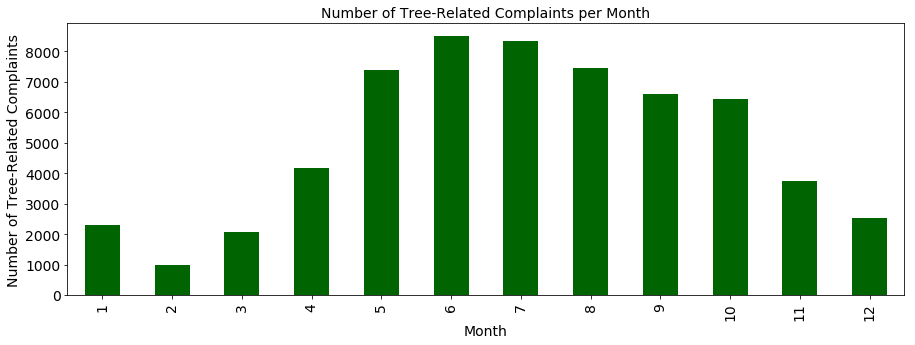

In [28]:
complaints['Created Date'] = pd.to_datetime(complaints['Created Date'])
complaints['Month'] = complaints['Created Date'].dt.month
complaints_month = complaints.groupby('Month').count()
complaints_month = complaints_month['Unique Key']
ax1=complaints_month.plot(kind="bar", color="darkgreen", figsize=(15,5), fontsize=14)
ax1.set_xlabel("Month", fontsize=14)
ax1.set_ylabel("Number of Tree-Related Complaints", fontsize=14)
ax1.set_title("Number of Tree-Related Complaints per Month", fontsize=14)

**Caption**: There is an unsurprising rise in tree complaints through the spring and summer, which slowy tapers off into fall and winter. 

#### Complaints per tree in each borough

In [29]:
boro_comp = pd.DataFrame(complaints['Borough'].value_counts().reset_index())
boro_comp.columns = ['Borough', 'Complaints']
boro_trees = pd.DataFrame(trees['borough'].value_counts().reset_index())
boro_trees.columns = ['Borough', 'Trees']
boroughs = pd.merge(boro_comp, boro_trees, on='Borough')
boroughs
boroughs['Complaints_per_tree'] = boroughs['Complaints'] / boroughs['Trees']
boroughs.sort_values('Complaints_per_tree', ascending=False)

,Borough,Complaints,Trees,Complaints_per_tree
1,Brooklyn,20980,177293,0.118335
0,Queens,22947,250551,0.091586
3,Manhattan,5214,65423,0.079697
2,Staten Island,6252,105318,0.059363
4,Bronx,5051,85203,0.059282


Text(0.5,1,'Complaints per tree by borough')

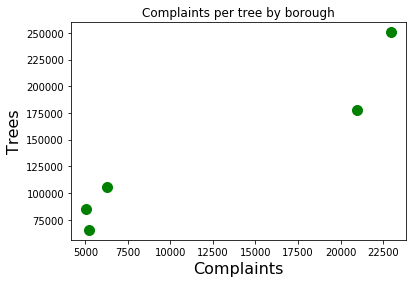

In [30]:
plt.scatter(boroughs['Complaints'], boroughs['Trees'], s=100, color='g')
plt.xlabel('Complaints', fontsize=16)
plt.ylabel('Trees', fontsize=16)
plt.title("Complaints per tree by borough")

#### Complaints per tree in each census tract

In [31]:
complaints_ct = geo_complaints.groupby(["GEOID", 'Complaint Type']).count()[['Unique Key']]
complaints_ct.reset_index(inplace=True)
complaints_ct = complaints_ct.pivot(index='GEOID', columns='Complaint Type', values='Unique Key')
complaints_ct.head()

Complaint Type,Damaged Tree,Dead Tree,Illegal Tree Damage,New Tree Request,Overgrown Tree/Branches
GEOID,,,,,
36005000200,14.0,4.0,NaN,6.0,7.0
36005000400,3.0,4.0,1.0,5.0,6.0
36005001600,5.0,4.0,3.0,NaN,1.0
36005001900,3.0,3.0,1.0,8.0,NaN
36005002000,6.0,4.0,NaN,NaN,20.0


In [32]:
total_complaints = geo_complaints.groupby(['GEOID']).count()[['Unique Key']]
total_complaints.reset_index(inplace=True)
total_complaints.set_index('GEOID', inplace=True)
total_complaints.columns = ['Total_Complaints']
total_complaints.head()

,Total_Complaints
GEOID,
36005000200,31
36005000400,19
36005001600,13
36005001900,15
36005002000,30


In [33]:
total_trees = geo_trees.groupby(['GEOID']).count()[['tree_id']]
total_trees.reset_index(inplace=True)

# total_trees.columns = [['GEOID', 'Total_Trees']]
# #total_trees = total_trees.pivot(index='GEOID', columns='tree_id', values='tree_id')
# #total_trees.rename_axis(None, inplace=True)
total_trees.set_index('GEOID', inplace=True)
total_trees.columns = ['Total_Trees']
print(total_trees.columns)
total_trees.head()

Index(['Total_Trees'], dtype='object')


,Total_Trees
GEOID,
36005000200,377
36005000400,478
36005001600,523
36005001900,508
36005002000,422


In [34]:
species_ct = geo_trees.groupby(['GEOID', 'spc_common']).count()[['tree_id']]
species_ct.reset_index(inplace=True)
species_ct = species_ct.pivot(index='GEOID', columns='spc_common', values='tree_id')
species_ct.head()

spc_common,'Schubert' chokecherry,American beech,American elm,American hophornbeam,American hornbeam,American larch,American linden,Amur cork tree,Amur maackia,Amur maple,...,tartar maple,tree of heaven,trident maple,tulip-poplar,two-winged silverbell,weeping willow,white ash,white oak,white pine,willow oak
GEOID,,,,,,,,,,,,,,,,,,,,,
36005000200,NaN,NaN,8.0,5.0,2.0,NaN,8.0,NaN,NaN,2.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN
36005000400,8.0,NaN,4.0,NaN,NaN,NaN,7.0,1.0,2.0,1.0,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
36005001600,15.0,1.0,10.0,NaN,4.0,NaN,8.0,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
36005001900,NaN,NaN,4.0,NaN,NaN,NaN,1.0,1.0,NaN,10.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36005002000,1.0,NaN,4.0,2.0,3.0,NaN,3.0,NaN,8.0,NaN,...,NaN,NaN,NaN,8.0,NaN,NaN,NaN,3.0,NaN,6.0


In [36]:
curb_ct = geo_trees.groupby(['GEOID', 'curb_loc']).count()[['tree_id']]
curb_ct.reset_index(inplace=True)
curb_ct = curb_ct.pivot(index='GEOID', columns='curb_loc', values='tree_id')
curb_ct.head()

curb_loc,OffsetFromCurb,OnCurb
GEOID,,
36005000200,11.0,366.0
36005000400,17.0,461.0
36005001600,19.0,504.0
36005001900,47.0,461.0
36005002000,7.0,415.0


In [37]:
guards_ct = geo_trees.groupby(['GEOID', 'guards']).count()[['tree_id']]
guards_ct.reset_index(inplace=True)
guards_ct = guards_ct.pivot(index='GEOID', columns='guards', values='tree_id')
guards_ct.rename(columns={'Harmful' : 'guards_harmful', 'Helpful' : 'guards_helpful', 'None' : 'guards_none'}, inplace=True)
guards_ct.head()

guards,guards_harmful,guards_helpful,guards_none,Unsure
GEOID,,,,
36005000200,4.0,9.0,361.0,2.0
36005000400,2.0,31.0,425.0,5.0
36005001600,2.0,44.0,454.0,3.0
36005001900,5.0,28.0,437.0,7.0
36005002000,3.0,14.0,388.0,3.0


In [38]:
guards_ct.columns

Index(['guards_harmful', 'guards_helpful', 'guards_none', 'Unsure'], dtype='object', name='guards')

In [39]:
total_complaints.columns

Index(['Total_Complaints'], dtype='object')

In [40]:
## Merging all data together 
df = pd.merge(total_complaints, total_trees, on='GEOID')
df = pd.merge(df, complaints_ct, on='GEOID')
df = pd.merge(df, curb_ct, on='GEOID')
df = pd.merge(df, guards_ct[['guards_harmful', 'guards_helpful', 'guards_none']], on='GEOID') 
df = pd.merge(df, census_data[['GEOID', 'Median_Income', 'Home_Owners']], on='GEOID')
df = pd.merge(df, species_ct, on='GEOID')

# Filling na
df = df.fillna(0).astype(int)
df['GEOID'] = df['GEOID'].astype(str)

## Adding in polygon for mapping
geo_df = pd.merge(df, census_shp[['GEOID', 'geometry']], on='GEOID')

print(geo_df.shape)
geo_df.set_index('GEOID', inplace=True)
geo_df.head()

(2088, 148)


,Total_Complaints,Total_Trees,Damaged Tree,Dead Tree,Illegal Tree Damage,New Tree Request,Overgrown Tree/Branches,OffsetFromCurb,OnCurb,guards_harmful,...,tree of heaven,trident maple,tulip-poplar,two-winged silverbell,weeping willow,white ash,white oak,white pine,willow oak,geometry
GEOID,,,,,,,,,,,,,,,,,,,,,
36005000200,31,377,14,4,0,6,7,11,366,4,...,0,0,1,0,0,0,1,0,0,"POLYGON ((-73.865218 40.814529, -73.864255 40...."
36005000400,19,478,3,4,1,5,6,17,461,2,...,3,0,0,0,0,0,0,1,0,"POLYGON ((-73.85870299999999 40.815405, -73.85..."
36005001600,13,523,5,4,3,0,1,19,504,2,...,0,0,0,0,0,0,0,0,9,"POLYGON ((-73.862464 40.819247, -73.861531 40...."
36005001900,15,508,3,3,1,8,0,47,461,5,...,1,0,0,0,0,0,0,0,0,"POLYGON ((-73.930938 40.808253, -73.929219 40...."
36005002000,30,422,6,4,0,0,20,7,415,3,...,0,0,8,0,0,0,3,0,6,"POLYGON ((-73.87050099999999 40.820364, -73.86..."


In [41]:
geo_df['Complaints_per_tree'] = geo_df['Total_Complaints'] / geo_df['Total_Trees']
geo_df.sort_values('Complaints_per_tree', ascending=False).head(10)

,Total_Complaints,Total_Trees,Damaged Tree,Dead Tree,Illegal Tree Damage,New Tree Request,Overgrown Tree/Branches,OffsetFromCurb,OnCurb,guards_harmful,...,trident maple,tulip-poplar,two-winged silverbell,weeping willow,white ash,white oak,white pine,willow oak,geometry,Complaints_per_tree
GEOID,,,,,,,,,,,,,,,,,,,,,
36047055800,209,200,14,14,0,176,5,0,200,5,...,0,0,1,0,1,0,0,0,"POLYGON ((-73.957724 40.6058, -73.955831 40.60...",1.045000
36047058600,160,171,6,3,0,144,7,0,171,3,...,0,0,0,0,1,0,0,1,"POLYGON ((-73.95692799999999 40.596612, -73.95...",0.935673
36047058000,174,221,12,2,5,150,5,0,221,1,...,0,0,0,0,0,1,0,0,"POLYGON ((-73.957757 40.600986, -73.95683 40.6...",0.787330
36047057800,130,209,4,18,1,96,11,2,207,2,...,0,0,0,0,0,0,0,0,"POLYGON ((-73.95397799999999 40.601401, -73.95...",0.622010
36005031900,2,4,0,0,0,0,2,0,4,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-73.91840499999999 40.917477, -73.91...",0.500000
36047033600,25,50,9,4,1,5,6,3,47,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-74.012996 40.578169, -74.0120188013...",0.500000
36081016400,66,139,18,6,1,6,35,0,139,1,...,0,0,0,0,1,0,0,0,"POLYGON ((-73.82146999999999 40.684891, -73.81...",0.474820
36047060000,185,420,16,29,1,128,11,7,413,6,...,0,1,0,0,0,0,0,0,"POLYGON ((-73.952276 40.58727200000001, -73.95...",0.440476
36047025902,3,7,0,0,0,0,3,0,7,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-73.946797 40.697903, -73.943949 40....",0.428571


In [42]:
## Dropping instances where there are fewer than 10 trees
print(geo_df.shape)
geo_df = geo_df[geo_df['Total_Trees'] > 10]
print(geo_df.shape)

(2088, 148)
(2085, 148)


In [43]:
## Make it a geodataframe for mapping
geo_df = gpd.GeoDataFrame(geo_df, geometry="geometry")
geo_df.shape

(2085, 148)

/anaconda3/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


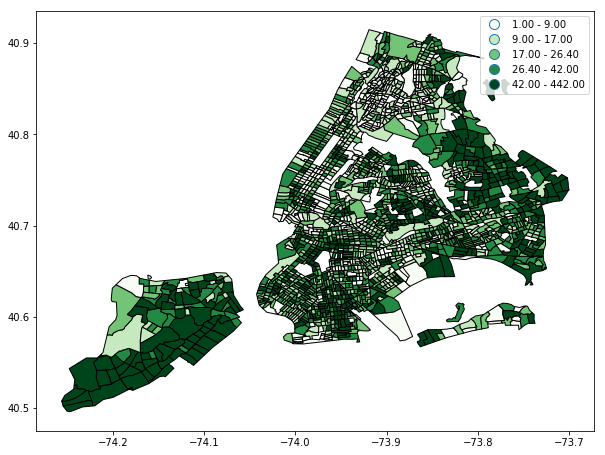

In [44]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
geo_df.plot(column='Total_Complaints', ax=ax, cmap='Greens', edgecolor='k', scheme='quantiles', legend=True)
plt.show()

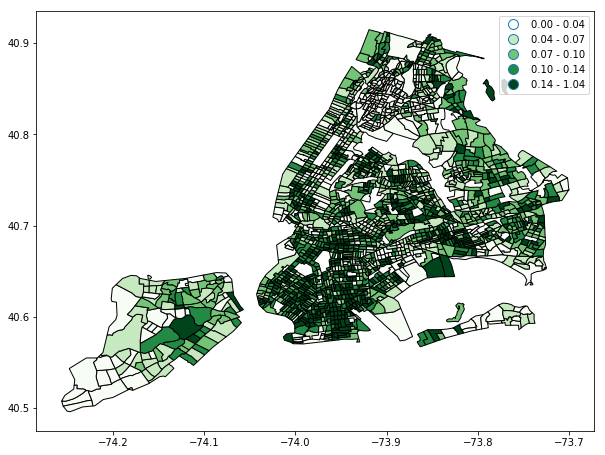

In [45]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
geo_df.plot(column='Complaints_per_tree', ax=ax, cmap='Greens', edgecolor='k', scheme='quantiles', legend=True)
plt.show()

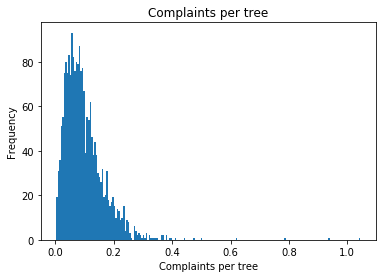

In [46]:
plt.hist(geo_df['Complaints_per_tree'], bins=200)
plt.title('Complaints per tree')
plt.xlabel('Complaints per tree')
plt.ylabel('Frequency')
plt.show()

# Regression

In [47]:
## Setting target variable
y = geo_df['Complaints_per_tree']

## Setting the predictors 
X = geo_df.iloc[:, 7:146]

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Complaints_per_tree   R-squared:                       0.642
Model:                             OLS   Adj. R-squared:                  0.616
Method:                  Least Squares   F-statistic:                     25.08
Date:                 Thu, 16 Aug 2018   Prob (F-statistic):               0.00
Time:                         18:05:16   Log-Likelihood:                 2487.2
No. Observations:                 2085   AIC:                            -4696.
Df Residuals:                     1946   BIC:                            -3912.
Df Model:                          139                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
OffsetFromCurb             0.0002      0.000      0.758      0.449      -0.000       0.001
OnCurb                     0.0009      0.000      4.008      0.000       0.000       0.001
guards_harmful            -0.0006      0.000     -1.612      0.107      -0.001       0.000
guards_helpful            -0.0002      0.000     -0.492      0.622      -0.001       0.000
guards_none               -0.0001      0.000     -0.413      0.679      -0.001       0.000
Median_Income            1.81e-06   8.31e-08     21.788      0.000    1.65e-06    1.97e-06
Home_Owners             1.911e-05   2.38e-06      8.044      0.000    1.45e-05    2.38e-05
'Schubert' chokecherry    -0.0007      0.001     -1.063      0.288      -0.002       0.001
American beech             0.0004      0.003      0.116      0.908      -0.006       0.007
American elm              -0.0008      0.000     -1.636      0.102      -0.002       0.000
American hophornbeam      -0.0015      0.001     -1.054      0.292      -0.004       0.001
American hornbeam         -0.0015      0.001     -1.299      0.194      -0.004       0.001
American larch             0.0018      0.010      0.184      0.854      -0.018       0.021
American linden           -0.0004      0.000     -0.879      0.379      -0.001       0.001
Amur cork tree            -0.0029      0.002     -1.488      0.137      -0.007       0.001
Amur maackia              -0.0002      0.001     -0.223      0.824      -0.002       0.002
Amur maple                -0.0012      0.001     -1.436      0.151      -0.003       0.000
Atlantic white cedar       0.0006      0.002      0.284      0.776      -0.004       0.005
Atlas cedar                0.0012      0.004      0.328      0.743      -0.006       0.008
Callery pear              -0.0008      0.000     -2.112      0.035      -0.002   -5.86e-05
Chinese chestnut           0.0017      0.004      0.440      0.660      -0.006       0.009
Chinese elm            -3.782e-05      0.001     -0.064      0.949      -0.001       0.001
Chinese fringetree        -0.0033      0.004     -0.918      0.359      -0.010       0.004
Chinese tree lilac        -0.0053      0.002     -2.597      0.009      -0.009      -0.001
Cornelian cherry           0.0016      0.001      1.241      0.215      -0.001       0.004
Douglas-fir               -0.0009      0.006     -0.165      0.869      -0.012       0.010
English oak               -0.0008      0.001     -0.878      0.380      -0.003       0.001
European alder            -0.0019      0.007     -0.262      0.794      -0.016       0.012
European beech             0.0015      0.005      0.296      0.767      -0.009       0.012
European hornbeam         -0.0020      0.001     -2.369      0.018      -0.004      -0.000
Himalayan cedar           -0.0016      0.006     -0.273      0.785   

In [48]:
## Doing regression with smaller subset of variables 

## Setting target variable
y = geo_df['Complaints_per_tree']

## Setting the predictors -- excluding all tree species data 
X = geo_df.iloc[:, 7:14]

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Complaints_per_tree   R-squared:                       0.593
Model:                             OLS   Adj. R-squared:                  0.591
Method:                  Least Squares   F-statistic:                     432.1
Date:                 Thu, 16 Aug 2018   Prob (F-statistic):               0.00
Time:                         18:05:16   Log-Likelihood:                 2353.6
No. Observations:                 2085   AIC:                            -4693.
Df Residuals:                     2078   BIC:                            -4654.
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
OffsetFromCurb    -0.0002      0.000     -0.964      0.335      -0.001       0.000
OnCurb             0.0005      0.000      3.015      0.003       0.000       0.001
guards_harmful    -0.0011      0.000     -5.671      0.000      -0.002      -0.001
guards_helpful    -0.0006      0.000     -3.466      0.001      -0.001      -0.000
guards_none       -0.0005      0.000     -3.163      0.002      -0.001      -0.000
Median_Income   2.026e-06   7.53e-08     26.908      0.000    1.88e-06    2.17e-06
Home_Owners     2.045e-05   2.19e-06      9.341      0.000    1.62e-05    2.47e-05
==============================================================================
Omnibus:                     1333.957   Durbin-Watson:                   1.484
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            48462.898
Skew:                           2.460   Prob(JB):                         0.00
Kurtosis:                      26.101   Cond. No.                     8.97e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Decision Tree

In [49]:
## Adding a binary target variable: higher or lower than average complaints 
geo_df['complaints_binary'] = 0
geo_df.loc[geo_df['Complaints_per_tree'] >= geo_df['Complaints_per_tree'].mean(), ['complaints_binary']] = 1

In [50]:
geo_df[::555]

,Total_Complaints,Total_Trees,Damaged Tree,Dead Tree,Illegal Tree Damage,New Tree Request,Overgrown Tree/Branches,OffsetFromCurb,OnCurb,guards_harmful,...,tulip-poplar,two-winged silverbell,weeping willow,white ash,white oak,white pine,willow oak,geometry,Complaints_per_tree,complaints_binary
GEOID,,,,,,,,,,,,,,,,,,,,,
36005000200,31,377,14,4,0,6,7,11,366,4,...,1,0,0,0,1,0,0,"POLYGON ((-73.865218 40.814529, -73.864255 40....",0.082228,0
36047028300,10,148,2,1,0,5,2,7,141,0,...,2,0,0,0,0,0,0,"POLYGON ((-73.94352599999999 40.696031, -73.93...",0.067568,0
36061004800,38,271,10,9,4,10,5,0,271,30,...,0,0,0,0,0,0,1,"POLYGON ((-73.986679 40.733978, -73.9862129999...",0.140221,1
36081051200,46,548,12,8,5,2,19,26,522,1,...,3,1,0,3,0,1,0,"POLYGON ((-73.754037 40.71388, -73.74934499999...",0.083942,0


[0.560702875399361, 0.6277955271565495, 0.6565495207667732, 0.645367412140575, 0.6677316293929713, 0.646964856230032, 0.6629392971246006, 0.6517571884984026, 0.6549520766773163, 0.646964856230032]


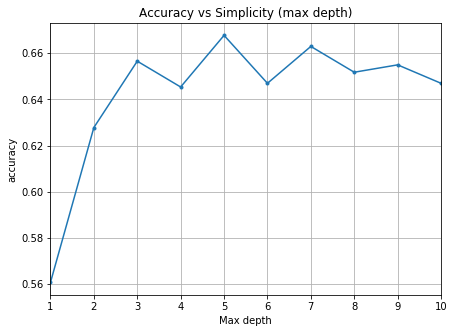

In [51]:
## Setting target variable
y = geo_df['complaints_binary']

## Setting the predictors 
x = geo_df.iloc[:, 7:146]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=999)

accuracy = []
for i in range(1,11):    
    dt = DecisionTreeClassifier(max_depth=i)
    dt.fit(X_train, y_train)
    y_predict = dt.predict(X_test)
    accuracy.append((y_predict == y_test).value_counts(normalize=True)[True])
print(accuracy)

plt.figure(figsize=(7,5))
plt.plot(range(1,11,1), accuracy, '.-')
plt.xlabel("Max depth")
plt.ylabel("accuracy")
plt.title("Accuracy vs Simplicity (max depth)")
plt.xlim(1,10)
plt.grid(True)
plt.show()

In [52]:
param_grid ={'max_depth' : range(1,11)}
dt = DecisionTreeClassifier()
gr=GridSearchCV(dt,param_grid=param_grid)
rs=gr.fit(X_train,y_train)
print('Best parameter value:', rs.best_params_)
y_predict = rs.predict(X_test)
print('Accuracy = ', ((y_predict == y_test).value_counts(normalize=True)[True]))

Best parameter value: {'max_depth': 3}
Accuracy =  0.6565495207667732


**Note** To view the graphic, you can also go to http://www.webgraphviz.com/ and copy/paste 'thestring'

digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname=helvetica] ;
edge [fontname=helvetica] ;
0 [label="Home_Owners <= 663.5, samples = 1459, value = [911, 548], class = low", fillcolor="#e5813966"] ;
1 [label="honeylocust <= 20.5, samples = 414, value = [346, 68], class = low", fillcolor="#e58139cd"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="Median_Income <= 27237.0, samples = 183, value = [134, 49], class = low", fillcolor="#e58139a2"] ;
1 -> 2 ;
3 [label="black cherry <= 3.5, samples = 96, value = [84, 12], class = low", fillcolor="#e58139db"] ;
2 -> 3 ;
4 [label="silver maple <= 3.5, samples = 94, value = [84, 10], class = low", fillcolor="#e58139e1"] ;
3 -> 4 ;
5 [label="samples = 86, value = [80, 6], class = low", fillcolor="#e58139ec"] ;
4 -> 5 ;
6 [label="samples = 8, value = [4, 4], class = low", fillcolor="#e5813900"] ;
4 -> 6 ;
7 [label="samples = 2, value = [0, 2], class = medium", fillcolor="#399de5ff"] ;
3 -> 7 ;

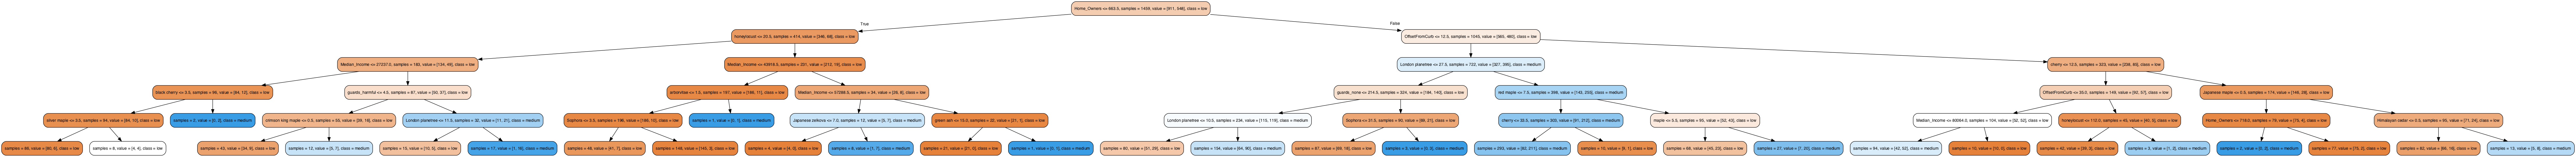

In [53]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train,y_train)
thestring=tree.export_graphviz(dt,out_file=None,
                         feature_names=X_train.columns.values,  
                         class_names=['low', 'medium', 'high', 'awful'],  
                         filled=True, rounded=True,  
                         special_characters=True,impurity=False).replace("<br/>",", ").replace("&le;","<=").replace("=<","=\"").replace(">,","\",")
print(thestring)
graph = pydotplus.graph_from_dot_data(thestring)
Image(graph.create_png())  

### Decision tree without tree species

[0.560702875399361, 0.6277955271565495, 0.5926517571884984, 0.6293929712460063, 0.6246006389776357, 0.6293929712460063, 0.6214057507987221, 0.5878594249201278, 0.5846645367412141, 0.5734824281150159]


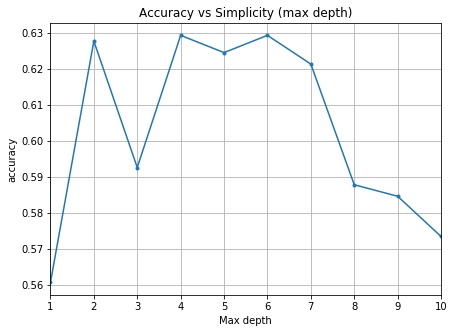

In [54]:
## Setting target variable
y = geo_df['complaints_binary']

## Setting the predictors 
x = geo_df.iloc[:, 7:14]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=999)

accuracy = []
for i in range(1,11):    
    dt = DecisionTreeClassifier(max_depth=i)
    dt.fit(X_train, y_train)
    y_predict = dt.predict(X_test)
    accuracy.append((y_predict == y_test).value_counts(normalize=True)[True])
print(accuracy)

plt.figure(figsize=(7,5))
plt.plot(range(1,11,1), accuracy, '.-')
plt.xlabel("Max depth")
plt.ylabel("accuracy")
plt.title("Accuracy vs Simplicity (max depth)")
plt.xlim(1,10)
plt.grid(True)
plt.show()

In [55]:
param_grid ={'max_depth' : range(1,11)}
dt = DecisionTreeClassifier()
gr=GridSearchCV(dt,param_grid=param_grid)
rs=gr.fit(X_train,y_train)
print('Best parameter value:', rs.best_params_)
y_predict = rs.predict(X_test)
print('Accuracy = ', ((y_predict == y_test).value_counts(normalize=True)[True]))

Best parameter value: {'max_depth': 4}
Accuracy =  0.6309904153354633


digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname=helvetica] ;
edge [fontname=helvetica] ;
0 [label="Home_Owners <= 663.5, samples = 1459, value = [911, 548], class = low", fillcolor="#e5813966"] ;
1 [label="Median_Income <= 27377.0, samples = 414, value = [346, 68], class = low", fillcolor="#e58139cd"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="guards_none <= 17.5, samples = 219, value = [202, 17], class = low", fillcolor="#e58139ea"] ;
1 -> 2 ;
3 [label="OffsetFromCurb <= 3.0, samples = 3, value = [1, 2], class = medium", fillcolor="#399de57f"] ;
2 -> 3 ;
4 [label="samples = 2, value = [0, 2], class = medium", fillcolor="#399de5ff"] ;
3 -> 4 ;
5 [label="samples = 1, value = [1, 0], class = low", fillcolor="#e58139ff"] ;
3 -> 5 ;
6 [label="guards_harmful <= 52.5, samples = 216, value = [201, 15], class = low", fillcolor="#e58139ec"] ;
2 -> 6 ;
7 [label="Home_Owners <= 574.5, samples = 215, value = [201, 14], class = low", f

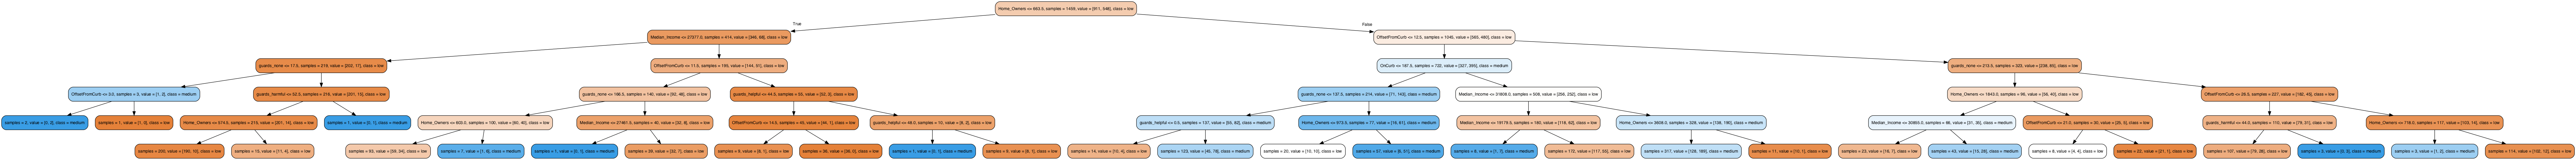

In [56]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train,y_train)
thestring=tree.export_graphviz(dt,out_file=None,
                         feature_names=X_train.columns.values,  
                         class_names=['low', 'medium', 'high', 'awful'],  
                         filled=True, rounded=True,  
                         special_characters=True,impurity=False).replace("<br/>",", ").replace("&le;","<=").replace("=<","=\"").replace(">,","\",")
print(thestring)
graph = pydotplus.graph_from_dot_data(thestring)
Image(graph.create_png())  

### Let's change the target variable to just be number of calls, irreseptive of number of trees. Is the number of trees the main predictor? 

In [57]:
y = geo_df.iloc[:, 0]
X = geo_df.iloc[:, 1:]
X.drop(['Damaged Tree', 'Dead Tree', 'Illegal Tree Damage', 'Overgrown Tree/Branches', 'New Tree Request'], axis=1, inplace=True)
X = X.iloc[:, :8]
X.head()

,Total_Trees,OffsetFromCurb,OnCurb,guards_harmful,guards_helpful,guards_none,Median_Income,Home_Owners
GEOID,,,,,,,,
36005000200,377,11,366,4,9,361,35406,3071
36005000400,478,17,461,2,31,425,42492,4374
36005001600,523,19,504,2,44,454,22279,1001
36005001900,508,47,461,5,28,437,31031,246
36005002000,422,7,415,3,14,388,21757,1791


In [58]:
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Total_Complaints   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     820.4
Date:                Thu, 16 Aug 2018   Prob (F-statistic):               0.00
Time:                        18:05:20   Log-Likelihood:                -9295.0
No. Observations:                2085   AIC:                         1.860e+04
Df Residuals:                    2078   BIC:                         1.864e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Total_Trees        0.0443      0.028      1.559      0.119      -0.011       0.100
OffsetFromCurb    -0.0932      0.021     -4.357      0.000      -0.135      -0.051
OnCurb             0.1374      0.016      8.567      0.000       0.106       0.169
guards_harmful    -0.1289      0.054     -2.390      0.017      -0.235      -0.023
guards_helpful    -0.1728      0.046     -3.746      0.000      -0.263      -0.082
guards_none       -0.1346      0.043     -3.138      0.002      -0.219      -0.051
Median_Income      0.0002   2.01e-05      8.588      0.000       0.000       0.000
Home_Owners        0.0054      0.001      9.309      0.000       0.004       0.007
==============================================================================
Omnibus:                     1337.699   Durbin-Watson:                   1.676
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49407.933
Skew:                           2.465   Prob(JB):                         0.00
Kurtosis:                      26.333   Cond. No.                     2.30e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.19e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Let's see what drives new tree requests

In [59]:
y = geo_df['New Tree Request']
X = geo_df.iloc[:, 1:14]
X.drop(['Damaged Tree', 'Dead Tree', 'Illegal Tree Damage', 'Overgrown Tree/Branches', 'New Tree Request'], axis=1, inplace=True)
X.head()

,Total_Trees,OffsetFromCurb,OnCurb,guards_harmful,guards_helpful,guards_none,Median_Income,Home_Owners
GEOID,,,,,,,,
36005000200,377,11,366,4,9,361,35406,3071
36005000400,478,17,461,2,31,425,42492,4374
36005001600,523,19,504,2,44,454,22279,1001
36005001900,508,47,461,5,28,437,31031,246
36005002000,422,7,415,3,14,388,21757,1791


In [60]:
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       New Tree Request   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     160.0
Date:                Thu, 16 Aug 2018   Prob (F-statistic):          2.02e-189
Time:                        18:05:20   Log-Likelihood:                -7910.5
No. Observations:                2085   AIC:                         1.584e+04
Df Residuals:                    2078   BIC:                         1.587e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Total_Trees        0.0495      0.015      3.385      0.001       0.021       0.078
OffsetFromCurb    -0.0097      0.011     -0.878      0.380      -0.031       0.012
OnCurb             0.0591      0.008      7.161      0.000       0.043       0.075
guards_harmful    -0.0987      0.028     -3.554      0.000      -0.153      -0.044
guards_helpful    -0.0799      0.024     -3.365      0.001      -0.126      -0.033
guards_none       -0.1050      0.022     -4.753      0.000      -0.148      -0.062
Median_Income   6.637e-05   1.03e-05      6.416      0.000    4.61e-05    8.67e-05
Home_Owners        0.0009      0.000      2.912      0.004       0.000       0.001
==============================================================================
Omnibus:                     2672.479   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           527287.026
Skew:                           6.874   Prob(JB):                         0.00
Kurtosis:                      79.684   Cond. No.                     2.30e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.19e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Visualizations

pearsonr correlation (0.6355358208567604, 2.6889098526845442e-236)


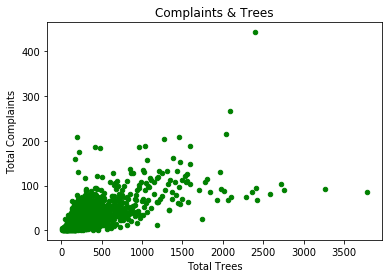

In [61]:
plt.scatter(geo_df['Total_Trees'], geo_df['Total_Complaints'], c='g', s=20)
plt.title("Complaints & Trees")
plt.xlabel("Total Trees")
plt.ylabel("Total Complaints")
print('pearsonr correlation', pearsonr(geo_df['Total_Trees'], geo_df['Total_Complaints']))

pearsonr correlation (0.2336071420414213, 3.0719915648804346e-27)


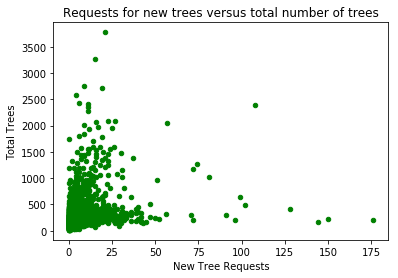

In [62]:
plt.scatter(geo_df['New Tree Request'], geo_df['Total_Trees'], c='g', s=20)
plt.title("Requests for new trees versus total number of trees")
plt.xlabel("New Tree Requests")
plt.ylabel("Total Trees")
print('pearsonr correlation', pearsonr(geo_df['New Tree Request'], geo_df['Total_Trees']))

**Caption** It does not appear that the total number of trees is very related to the number of requests per new trees. This suggests that even if an area has a lot of trees, they may still request more, and vica versa. 

pearsonr correlation (0.12603336891261102, 7.718258317897488e-09)


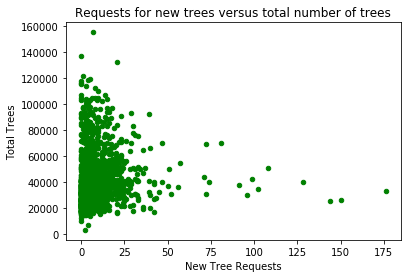

In [63]:
plt.scatter(geo_df['New Tree Request'], geo_df['Median_Income'], c='g', s=20)
plt.title("Requests for new trees versus total number of trees")
plt.xlabel("New Tree Requests")
plt.ylabel("Total Trees")
print('pearsonr correlation', pearsonr(geo_df['New Tree Request'], geo_df['Median_Income']))

# Findings & recommendations

- New Yorkers made over 60,000 calls to 311 about trees in 2015. That's over 160 calls per day. 
- Nearly 70% of all 311 complaints received by DPR relate to trees.
- Brooklyn has the highest number of complaints per tree, at 0.12 complaints per tree
- About 1% of tree-related complaints do not have a geocoded location.

# Next Steps / Further Analysis
- Deep clean tree species names to make sure there are no duplicates, etc.
- Consider potential issues of multicollinearity

# Skills Demonstrated
- Data gathering (downloads, direct link, API) 
- Data cleaning (Reshaping, dropping nans, data types, etc) 
- Data merging (Creating similar unique key) 
- Mapping/Spatial 
- Vizualizations 